In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = keras.utils.get_file("time_square.jpg", "https://cdn.britannica.com/66/154566-050-36E73C15/Times-Square-New-York-City.jpg")
style_reference_image_path = keras.utils.get_file(
    "p5_style.jpg", "https://i0.wp.com/twinfinite.net/wp-content/uploads/2020/03/Persona-5-Wallpapers-Pause.jpg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

229376/220401 [===============================] - 0s 0us/step


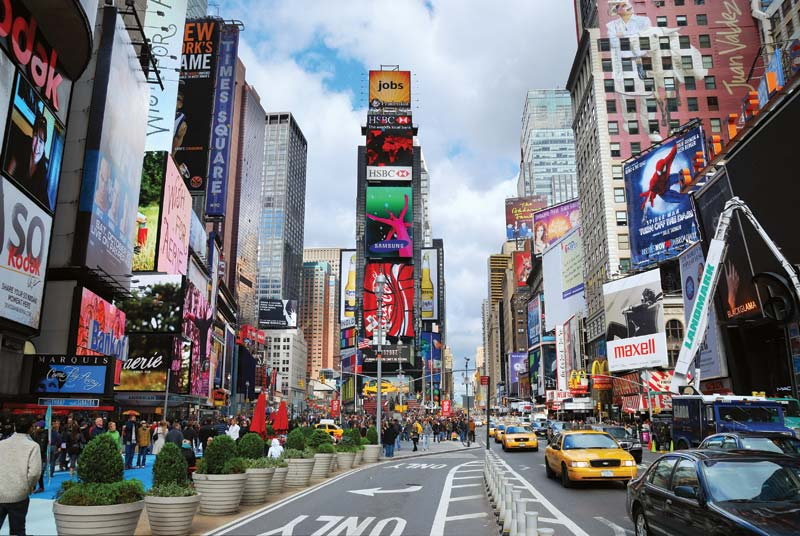

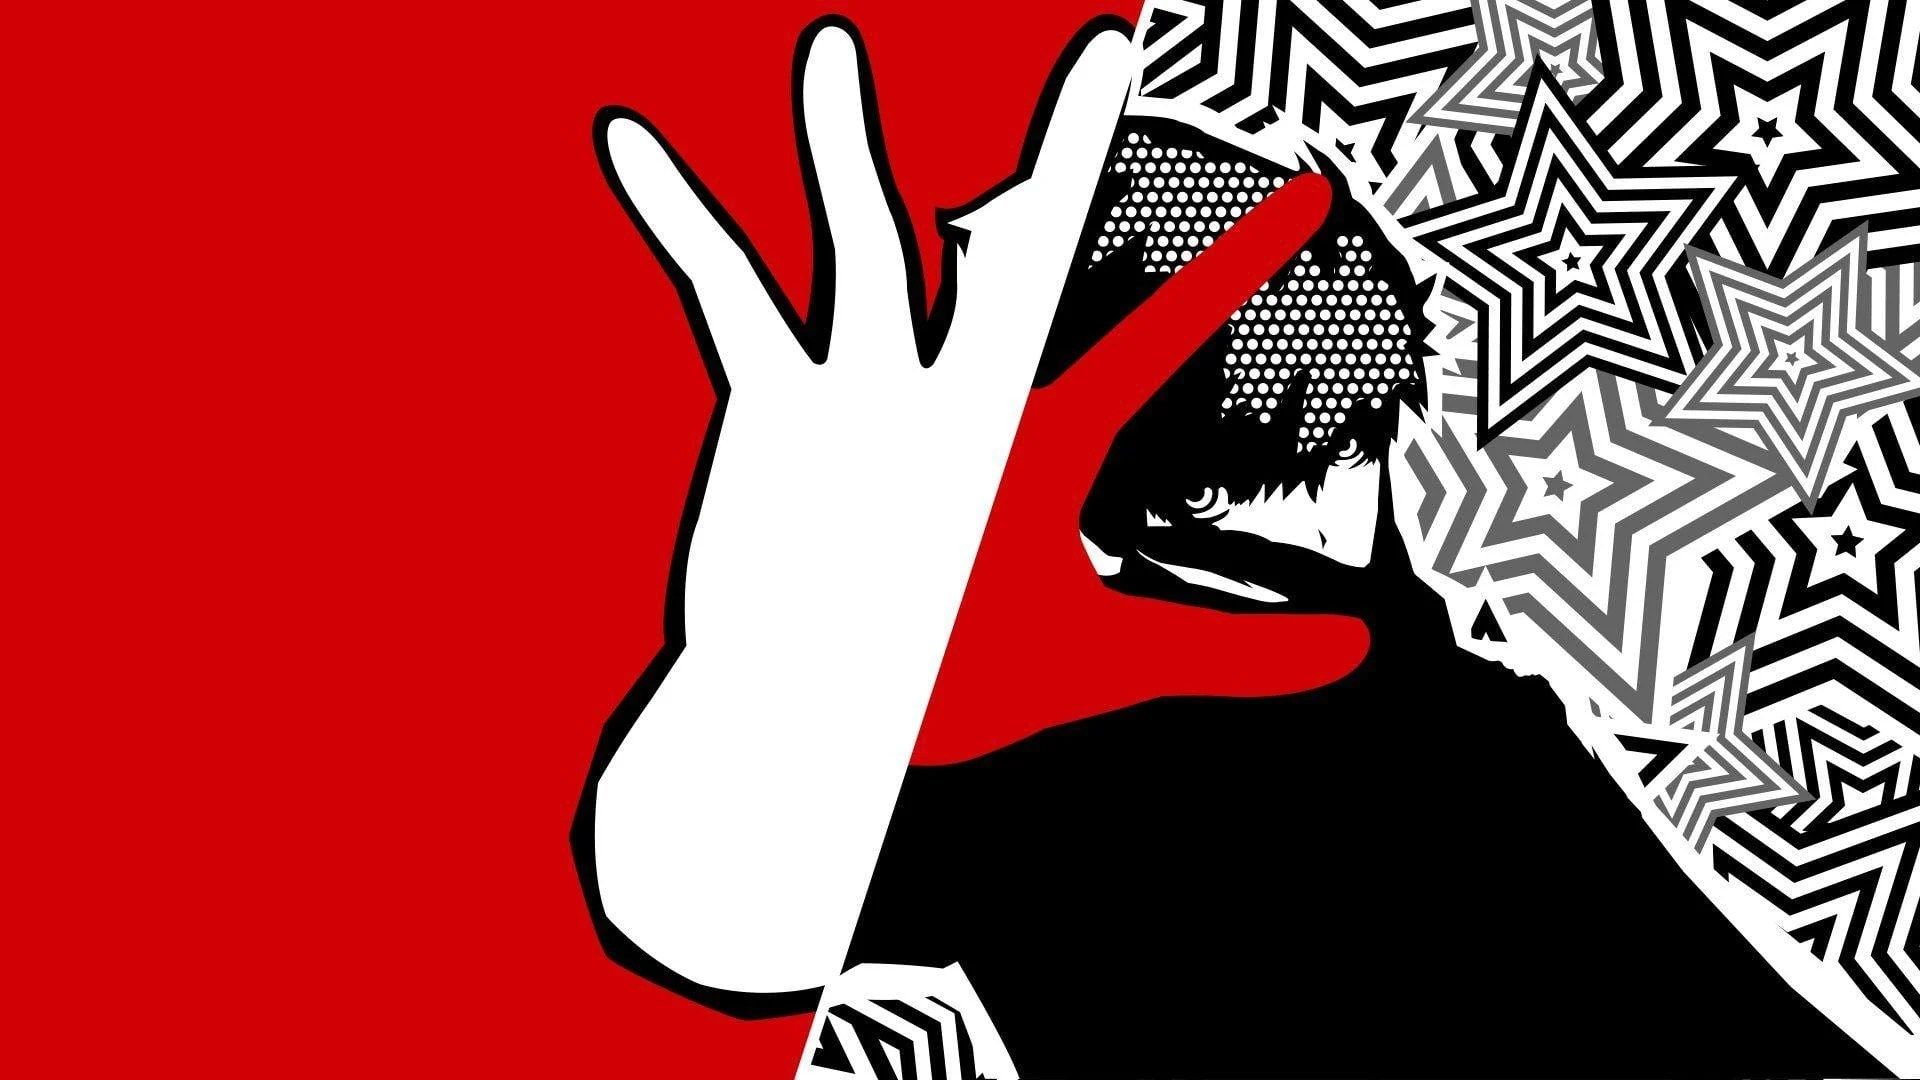

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [ ]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [ ]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))
    

In [ ]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(include_top=False, #czy włączyć 3 w pełni połączone warstwy w górnej części sieci.
    weights="imagenet", #  None (inicjalizacja losowa), ' imagenet '(szkolenie na ImageNet) lub ścieżka do pliku weights, który ma być załadowany.
    input_tensor=None, # opcjonalny tensor Keras (tj. wyjście layers.Input ()) do użycia jako wejście obrazu dla modelu.
    input_shape=None, # opcjonalna krotka kształtu, podawana tylko wtedy, gdy include_top ma wartość False (w przeciwnym razie kształt wejściowy musi być (224, 224, 3) (w formacie danych channels_last) lub (3, 224, 224) (w formacie danych channels_first). Powinien mieć dokładnie 3 kanały wejściowe, a szerokość i wysokość nie powinny być mniejsze niż 32. Np. (200, 200, 3) będzie jedną poprawną wartością.
    pooling='max', # include_top ma wartość False. None oznacza, że wyjście modelu będzie wyjściem tensora 4D ostatniego bloku splotu. avg oznacza, że globalny średni pooling zostanie zastosowany do wyjścia ostatniego bloku splotu, a zatem wyjście modelu będzie tensorem 2D. max oznacza, że zostanie zastosowany globalny Max pooling.
    classes=1000,   #opcjonalna liczba klas, do których można klasyfikować obrazy, może być podana tylko wtedy, gdy include_top ma wartość True i jeśli nie podano argumentu weights.
    classifier_activation="softmax", # classifier_activation może być tylko None lub "softmax".
)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)



In [ ]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss



In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.98
    )
)

In [ ]:
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=26703.92
Iteration 200: loss=22386.20
Iteration 300: loss=20783.14
Iteration 400: loss=19971.87
Iteration 500: loss=19501.24
Iteration 600: loss=19205.90
Iteration 700: loss=19014.93
Iteration 800: loss=18888.41
Iteration 900: loss=18802.97
Iteration 1000: loss=18744.78
Iteration 1100: loss=18704.76
Iteration 1200: loss=18677.08
Iteration 1300: loss=18657.88
Iteration 1400: loss=18644.53
Iteration 1500: loss=18635.23
Iteration 1600: loss=18628.74
Iteration 1700: loss=18624.21
Iteration 1800: loss=18621.04
Iteration 1900: loss=18618.82
Iteration 2000: loss=18617.27
Iteration 2100: loss=18616.18
Iteration 2200: loss=18615.42
Iteration 2300: loss=18614.89
Iteration 2400: loss=18614.52
Iteration 2500: loss=18614.26
Iteration 2600: loss=18614.08
Iteration 2700: loss=18613.96
Iteration 2800: loss=18613.88
Iteration 2900: loss=18613.84
Iteration 3000: loss=18613.82
Iteration 3100: loss=18613.80
Iteration 3200: loss=18613.80
Iteration 3300: loss=18613.80
Iteration 3400: los

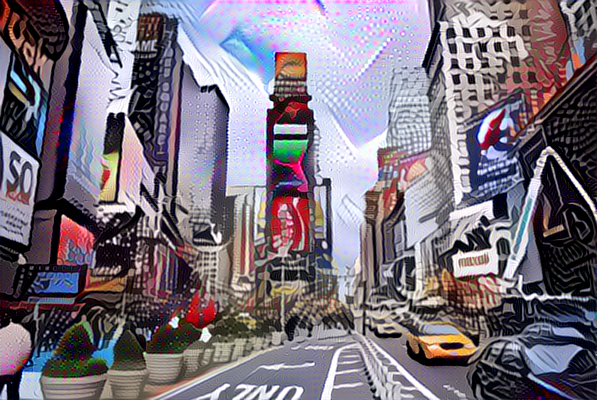

In [ ]:
display(Image(result_prefix + "_at_iteration_4000.png"))